# 🤖 Modelado Predictivo del Dataset

En esta sección se construyen modelos predictivos para estimar la probabilidad de éxito (*target*) de cada candidato.  
El objetivo es:

- Entrenar modelos supervisados que capturen la relación entre variables explicativas y target
- Evaluar la importancia de cada variable
- Comparar distintas técnicas y seleccionar la mejor
- Preparar submodelos según área académica (Medicina, Enfermería, resto)

El proceso se divide en los siguientes pasos:
1. Preparación de datos y división en entrenamiento/test  
2. Selección de modelos factibles  
3. Selección de variables importantes  
4. Entrenamiento de submodelos  
5. Optimización de hiperparámetros  
6. Evaluación del modelo sobre conjunto test

---

## 1️⃣ Preparación de Datos

Antes de entrenar los modelos:

- Se eliminan variables irrelevantes o identificadores
- Se manejan valores nulos
- Se divide el dataset en **conjunto de entrenamiento** (70–80 %) y **conjunto de test** (20–30 %)
- Se crean subdatasets si se requiere segmentación por área académica

📌 Esto asegura que el modelo no vea datos de test durante el entrenamiento, evitando sobreajuste.

---

## 2️⃣ Selección de Modelos

Se consideran modelos supervisados robustos para clasificación/regresión según el target:

- **Random Forest**: Modelo basado en árboles con gran capacidad de generalización  
- **Gradient Boosting Machines (GBM/XGBoost/LightGBM)**: Optimización secuencial de errores  
- **Regresiones**: Lineales o logísticas, útiles para interpretación  
- Otros modelos factibles según el caso (SVM, redes neuronales simples)

Se busca evaluar cuál combina mejor:

- Precisión o % acierto
- AUC (Área bajo la curva ROC)
- Interpretabilidad
- Robustez ante outliers y variables correlacionadas

---

## 3️⃣ Selección de Variables Importantes

- Se utiliza la importancia que cada modelo asigna a las variables para:

  - Reducir dimensionalidad
  - Evitar ruido
  - Mejorar interpretabilidad

- Variables con mayor impacto en la predicción serán prioridad para la construcción de submodelos.

📌 Ejemplo: `feature_importances_` en Random Forest o `SHAP values` para interpretabilidad avanzada.

---

## 4️⃣ Entrenamiento de Submodelos

- Se pueden crear modelos específicos para segmentos de interés:  
  - Medicina  
  - Enfermería  
  - Resto de candidatos

- Esto permite capturar patrones particulares de cada área que un modelo general podría diluir.

---

## 5️⃣ Optimización de Hiperparámetros

- Se aplican técnicas de tuning automático (grid search, random search o frameworks como **PyCaret**)  
- Se buscan combinaciones que maximizan métricas clave:  

  - Precisión / Recall  
  - AUC / ROC  
  - F1-score  

- El objetivo es **obtener el mejor modelo posible** sin sobreajustar a los datos de entrenamiento.

---

## 6️⃣ Evaluación en Conjunto de Test

- Una vez seleccionado el modelo óptimo, se evalúa sobre datos no vistos:

  - Comprobando métricas globales: % acierto, AUC  
  - Detectando posibles sesgos por segmento  
  - Verificando estabilidad y consistencia de predicciones

- Esto garantiza que el modelo generalice y pueda usarse para predicciones futuras.

---

## 🔍 Conclusiones del Modelado

El modelado supervisado permite:

- Predecir con alta fiabilidad la probabilidad de éxito de los candidatos  
- Entender qué variables tienen mayor impacto en la conversión  
- Construir estrategias segmentadas por áreas académicas  
- Complementar el análisis de clusters previo, combinando insights no supervisados y supervisados

📌 Los resultados servirán como base para:

- Implementación de modelos en producción
- Definición de estrategias de admisión diferenciadas
- Análisis de riesgo y priorización de candidatos


Variables utilizadas para modelado (43):
['ACCOUNTID', 'ID', 'ID18__PC', 'desmatriculado', 'PL_CURSO_ACADEMICO', 'CH_NACIONAL', 'NU_NOTA_MEDIA_ADMISION', 'NU_NOTA_MEDIA_1_BACH__PC', 'CH_PRUEBAS_CALIFICADAS', 'NU_RESULTADO_ADMISION_PUNTOS', 'PL_RESOLUCION_DEFINITIVA', 'TITULACION', 'CENTROENSENANZA', 'MINIMUMPAYMENTPAYED', 'PAID_PERCENT', 'CH_PAGO_SUPERIOR', 'CH_MATRICULA_SUJETA_BECA', 'CH_AYUDA_FINANCIACION', 'CU_IMPORTE_TOTAL', 'CH_VISITACAMPUS__PC', 'CH_ENTREVISTA_PERSONAL__PC', 'ACC_DTT_FECHAULTIMAACTIVIDAD', 'NU_PREFERENCIA', 'STAGENAME', 'PL_SUBETAPA', 'CH_HIJO_EMPLEADO__PC', 'CH_HIJO_PROFESOR_ASOCIADO__PC', 'CH_HERMANOS_ESTUDIANDO_UNAV__P', 'CH_HIJO_MEDICO__PC', 'YEARPERSONBIRTHDATE', 'NAMEX', 'CH_FAMILIA_NUMEROSA__PC', 'PL_SITUACION_SOCIO_ECONOMICA', 'LEADSOURCE', 'PL_ORIGEN_DE_SOLICITUD', 'PL_PLAZO_ADMISION', 'RECORDTYPENAME', 'PLAZO_ADMISION_LIMPIO', 'FO_rentaFam_ges__c', 'CU_precioOrdinario_def__c', 'CU_precioAplicado_def__c', 'num_asistencias_acum', 'num_solicitudes_acum']
T

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6130,0.5369,0.0078,0.7569,0.0154,0.0075,0.0478,0.1833
dt,Decision Tree Classifier,0.6131,0.5369,0.0078,0.7602,0.0154,0.0076,0.0481,0.1533
rf,Random Forest Classifier,0.6131,0.5369,0.0078,0.7602,0.0154,0.0076,0.0481,0.7400
lightgbm,Light Gradient Boosting Machine,0.6130,0.5369,0.0078,0.7569,0.0154,0.0075,0.0478,0.3767



Top 3 modelos seleccionados:
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=42, splitter='best')
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_sam

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6130,0.5369,0.0078,0.7554,0.0155,0.0076,0.0478
1,0.6127,0.5365,0.0070,0.7277,0.0138,0.0065,0.0425
2,0.6134,0.5372,0.0085,0.7875,0.0168,0.0086,0.0530
Mean,0.6130,0.5369,0.0078,0.7569,0.0154,0.0075,0.0478
Std,0.0003,0.0003,0.0006,0.0244,0.0012,0.0009,0.0043


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6129,0.5367,0.0069,0.7797,0.0137,0.0069,0.0472
1,0.6125,0.5363,0.0061,0.7391,0.0121,0.0058,0.0408
2,0.6131,0.5368,0.0073,0.7985,0.0145,0.0075,0.0502
Mean,0.6128,0.5366,0.0068,0.7725,0.0134,0.0067,0.0460
Std,0.0002,0.0002,0.0005,0.0248,0.0010,0.0007,0.0039


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6130,0.5369,0.0078,0.7554,0.0155,0.0076,0.0478
1,0.6127,0.5365,0.0070,0.7277,0.0138,0.0065,0.0425
2,0.6134,0.5372,0.0085,0.7875,0.0168,0.0086,0.0530
Mean,0.6130,0.5369,0.0078,0.7569,0.0154,0.0075,0.0478
Std,0.0003,0.0003,0.0006,0.0244,0.0012,0.0009,0.0043


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

Evaluación de modelo: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


Evaluación de modelo: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=42, splitter='best')


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


Evaluación de modelo: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6132,0.5372,0.0078,0.7888,0.0154,0.0079,0.0509



Resultados en test para modelo: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
        desmatriculado  num_asistencias_acum  num_solicitudes_acum  target  \
488499             0.0                     0                     0     0.0   
385507             0.0                     0                     0     1.0   
118424             0.0                     0                     0     0.0   
99750              0.0                     0                     0     1.0   
269058             1.0                     0                     0     0.0   

        prediction_label  prediction_score  
488499                 0            0.5954  
385507                 0            0.5954  
118424                 0            0.

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.6132,0.5372,0.0077,0.7897,0.0153,0.0078,0.0508



Resultados en test para modelo: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, random_state=42, splitter='best')
        desmatriculado  num_asistencias_acum  num_solicitudes_acum  target  \
488499             0.0                     0                     0     0.0   
385507             0.0                     0                     0     1.0   
118424             0.0                     0                     0     0.0   
99750              0.0                     0                     0     1.0   
269058             1.0                     0                     0     0.0   

        prediction_label  prediction_score  
488499                 0            0.5956  
385507                 0         

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.6132,0.5372,0.0077,0.7897,0.0153,0.0078,0.0508



Resultados en test para modelo: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=42, verbose=0,
                       warm_start=False)
        desmatriculado  num_asistencias_acum  num_solicitudes_acum  target  \
488499             0.0                     0                     0     0.0   
385507             0.0                     0                     0     1.0   
118424             0.0                     0                     0     0.0   
99750              0.0                     0                     0     1.0   
269058             1.0                 

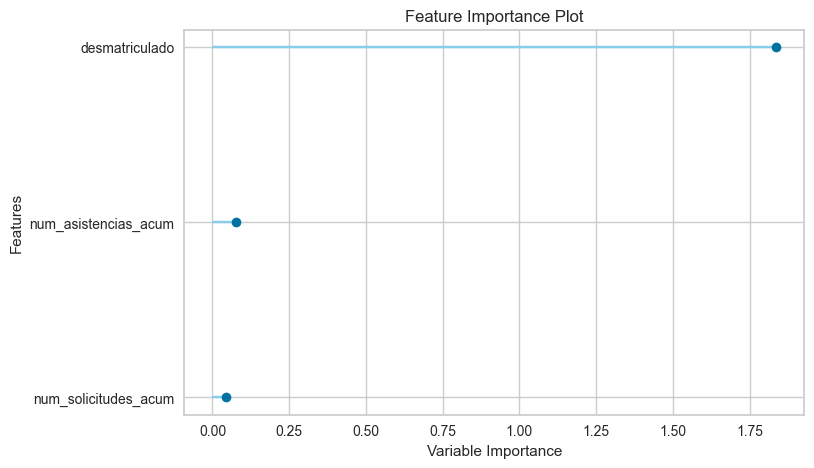

Transformation Pipeline and Model Successfully Saved

Modelos guardados correctamente.


In [16]:
# ============================================================
# SCRIPT · 03 MODELADO PREDICTIVO CON PYCARET (OPTIMIZADO)
# ============================================================

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pycaret.classification import (
    setup, compare_models, tune_model, evaluate_model,
    predict_model, plot_model, save_model
)

# ============================================================
# 0️⃣ CARGA DEL DATASET
# ============================================================

ruta_dataset = r"..\datos\03. Datos analizados\dataset_clusterizado.csv"
df = pd.read_csv(ruta_dataset, sep=";")
target = 'target'

df = df.dropna(subset=[target])

# ============================================================
# 1️⃣ SELECCIÓN DE VARIABLES
# ============================================================

vars_excluir = [
    'cluster', 'interpretacion_cluster', 'PCA1', 'PCA2',
    'PORCENTAJE_PAGADO_FINAL', 'PAID_AMOUNT',
    'tiempo_etapa_dias', 'tiempo_entre_etapas_dias'
]

vars_modelado = [c for c in df.columns if c not in vars_excluir + [target]]
vars_modelado_seleccionadas = vars_modelado  # ajustar según necesidad

X = df[vars_modelado_seleccionadas]
y = df[target]

print(f"Variables utilizadas para modelado ({len(vars_modelado_seleccionadas)}):")
print(vars_modelado_seleccionadas)

# ============================================================
# 2️⃣ DIVISIÓN ENTRENAMIENTO / TEST
# ============================================================

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Tamaño entrenamiento: {X_train.shape}, test: {X_test.shape}")

# ============================================================
# 3️⃣ FILTRAR COLUMNAS PROBLEMÁTICAS
# ============================================================

object_cols = X_train.select_dtypes(include=['object']).columns.tolist()
const_cols = X_train.columns[X_train.nunique() <= 1].tolist()
nan_cols = X_train.columns[X_train.isna().any()].tolist()

safe_cols = [c for c in X_train.columns if c not in object_cols + const_cols + nan_cols]

train_df = X_train[safe_cols].copy()
train_df[target] = y_train

# ============================================================
# 4️⃣ CONFIGURACIÓN DE PYCARET
# ============================================================

clf_setup = setup(
    data=train_df,
    target=target,
    train_size=0.8,
    session_id=42,
    normalize=True,
    transformation=False,
    fold=3,           # Validación cruzada más rápida
    verbose=False,
    ignore_features=object_cols + const_cols + nan_cols
)

# ============================================================
# 5️⃣ COMPARACIÓN DE MODELOS (solo rápidos)
# ============================================================

best_models = compare_models(
    include=['lr', 'dt', 'rf', 'lightgbm'],  # solo modelos rápidos
    sort='AUC',
    n_select=3,
    turbo=True   # usa turbo mode para acelerar
)

print("\nTop 3 modelos seleccionados:")
for m in best_models:
    print(m)

# ============================================================
# 6️⃣ TUNING DE HIPERPARÁMETROS (rápido)
# ============================================================

tuned_models = [
    tune_model(m, optimize='AUC', n_iter=10, choose_better=True) 
    for m in best_models
]

# ============================================================
# 7️⃣ EVALUACIÓN DE MODELOS
# ============================================================

for tm in tuned_models:
    print(f"\nEvaluación de modelo: {tm}")
    evaluate_model(tm)

# ============================================================
# 8️⃣ VALIDACIÓN SOBRE TEST
# ============================================================

test_df = X_test[safe_cols].copy()
test_df[target] = y_test

for tm in tuned_models:
    preds = predict_model(tm, data=test_df)
    print(f"\nResultados en test para modelo: {tm}")
    print(preds.head())

# ============================================================
# 9️⃣ IMPORTANCIA DE VARIABLES
# ============================================================

plot_model(tuned_models[0], plot='feature')

# ============================================================
# 🔟 SUBMODELOS POR ÁREA (solo si existe la columna, y optimizado)
# ============================================================

if 'area' in df.columns:
    areas = df['area'].unique()
    submodel_results = {}

    for area in areas:
        sub_df = df[df['area'] == area].dropna(subset=[target])
        X_sub = sub_df[vars_modelado_seleccionadas]
        y_sub = sub_df[target]
        
        X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(
            X_sub, y_sub, test_size=0.2, random_state=42, stratify=y_sub
        )
        
        safe_sub = [c for c in X_train_sub.columns 
                    if c not in X_train_sub.select_dtypes(include=['object']).columns.tolist() +
                            X_train_sub.columns[X_train_sub.nunique() <= 1].tolist() +
                            X_train_sub.columns[X_train_sub.isna().any()].tolist()]

        train_sub_df = X_train_sub[safe_sub].copy()
        train_sub_df[target] = y_train_sub
        
        setup_sub = setup(
            data=train_sub_df,
            target=target,
            train_size=0.8,
            session_id=42,
            normalize=True,
            transformation=False,
            fold=3,          # fold más rápido
            verbose=False,
            ignore_features=[]
        )
        
        best_model_sub = compare_models(
            include=['lr', 'dt', 'rf', 'lightgbm'],
            sort='AUC',
            n_select=1,
            turbo=True
        )
        tuned_model_sub = tune_model(best_model_sub[0], optimize='AUC', n_iter=5, choose_better=True)
        
        test_sub_df = X_test_sub[safe_sub].copy()
        test_sub_df[target] = y_test_sub
        preds_sub = predict_model(tuned_model_sub, data=test_sub_df)
        
        submodel_results[area] = {'modelo': tuned_model_sub, 'predicciones_test': preds_sub}
        print(f"Predicciones test ({area}):")
        print(preds_sub.head())

# ============================================================
# 1️⃣1️⃣ GUARDAR MODELOS
# ============================================================

save_model(tuned_models[0], r"..\datos\04. Modelos")
if 'area' in df.columns:
    for area, info in submodel_results.items():
        save_model(info['modelo'], rf"..\datos\04. Modelos\modelo_{area}")

print("\nModelos guardados correctamente.")
